In [1]:
%load_ext autoreload
%autoreload 2
import os
import os.path as osp
import sys
import json
import numpy as np
import plyfile
import pyvista as pv
import accelerate
from easydict import EasyDict as edict
from termcolor import colored

sys.path.append(os.path.join(os.getcwd(), '..'))

/home/lyy/miniconda3/envs/instruct-insertion/lib/python3.9/site-packages/tqdm-4.66.1-py3.9.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Environment Setup

In [2]:
def is_vscode() -> bool:
    for var in os.environ:
        if var == "VSCODE_CWD":
            return True
    return False

if is_vscode():
    print(colored("Vscode jupyter DOESN'T support pyvista interative mode", "yellow", force_color=True))
    jupyter_backend = "static"
else:
    jupyter_backend = "trame"

# set this if on remote jupyter
# for headless linux users
os.environ["DISPLAY"] = ":99.0"
os.environ["PYVISTA_OFF_SCREEN"] = "true"
# NOTE: vscode remote jupyter does not work with pyvista
if not is_vscode():
    pv.global_theme.trame.server_proxy_enabled = True

Vscode jupyter DOESN'T support pyvista interative mode


In [11]:
accelerator = accelerate.Accelerator()
device = accelerator.device
device

device(type='cuda')

## Prepare data & models

In [4]:
# load existing args
PROJECT_TOP_DIR = "../../tmp_link_saves"
PROJECT_DIR = osp.join(PROJECT_TOP_DIR, "rpp_fps")
with open(osp.join(PROJECT_DIR, "config.json.txt"), "r") as f:
    args = edict(json.load(f))

In [5]:
from data.referit3d.in_out.neural_net_oriented import load_scan_related_data
# load data
SCANNET_PKL_FILE = "../../datasets/scannet/instruct/global_small.pkl"
_all_scans_in_dict, _scans_split, class_to_idx = load_scan_related_data(SCANNET_PKL_FILE)

In [6]:
from transformers import BertTokenizer
# prepare tokenizer
tokenizer = BertTokenizer.from_pretrained(args.bert_pretrain_path)
# Prepare the Listener
n_classes = len(class_to_idx) - 1  # -1 to ignore the <pad> class
pad_idx = class_to_idx["pad"]
# Object-type classification
class_name_list = list(class_to_idx.keys())

class_name_tokens = tokenizer(class_name_list, return_tensors="pt", padding=True)
class_name_tokens = class_name_tokens.to(device)

In [8]:
from models.referit3d_model.referit3d_net import ReferIt3DNet_transformer
from models.point_e_model.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from models.point_e_model.diffusion.sampler import PointCloudSampler
from models.point_e_model.models.configs import MODEL_CONFIGS, model_from_config

# referit3d model
mvt3dvg = ReferIt3DNet_transformer(args, n_classes, class_name_tokens, ignore_index=pad_idx)
# point-e model
point_e_config = MODEL_CONFIGS[args.point_e_model]
point_e_config["cache_dir"] = osp.join(PROJECT_TOP_DIR, "cache", "point_e_model")
point_e_config["n_ctx"] = args.points_per_object
point_e = model_from_config(point_e_config, device)
point_e_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[args.point_e_model])
# move models to gpu
mvt3dvg = mvt3dvg.to(device)
point_e = point_e.to(device)

In [12]:
# load model and checkpoints
mvt3dvg, point_e = accelerator.prepare(mvt3dvg, point_e)
CHECKPOINT_DIR = osp.join(PROJECT_DIR, "checkpoints", "2023-09-12_11-31-26", "ckpt_160000")
accelerator.load_state(CHECKPOINT_DIR)

## Visualization

In [ ]:
# TODO - replace last_pcs with the real point cloud
last_pcs = torch.randn(1, 1024, 7)
vis_pc = last_pcs.squeeze() # (P, 7)

pos = vis_pc[:, :3]
aux = vis_pc[:, 3:]

coords = (
    pos * batch["tgt_box_max_dist"][0] + batch["tgt_box_center"][0]
)
colors = aux.mul_(255.0)  # (P, 3 or 4)
vis_pc = torch.cat((coords, colors), dim=-1)  # (P, 6 or 7)

# Process the color in the scene
ctx_pc = batch["ctx_pc"][0].reshape(-1, 7) # (# of context * P, 7)
ctx_pos = ctx_pc[:, :3]
ctx_color = ctx_pc[:, 3:].mul_(255.0) # color in ctx has been normalized
ctx_pc = torch.cat((ctx_pos, ctx_color), dim=-1) # (# of context * P, 6 or 7)

# Add object into scene
vis_pc = torch.cat((vis_pc, ctx_pc), dim=0) # (P + # of context * P, 7)


1. Create a pyvista point cloud object and generate mesh

In [5]:
# Create a pyvista point cloud object
cloud = pv.PolyData(vis_pc[:, :3])

# Generate the mesh
mesh = cloud.delaunay_2d()
colors = vis_pc[:, 3:6].astype(np.uint8)

2. Plot the mesh

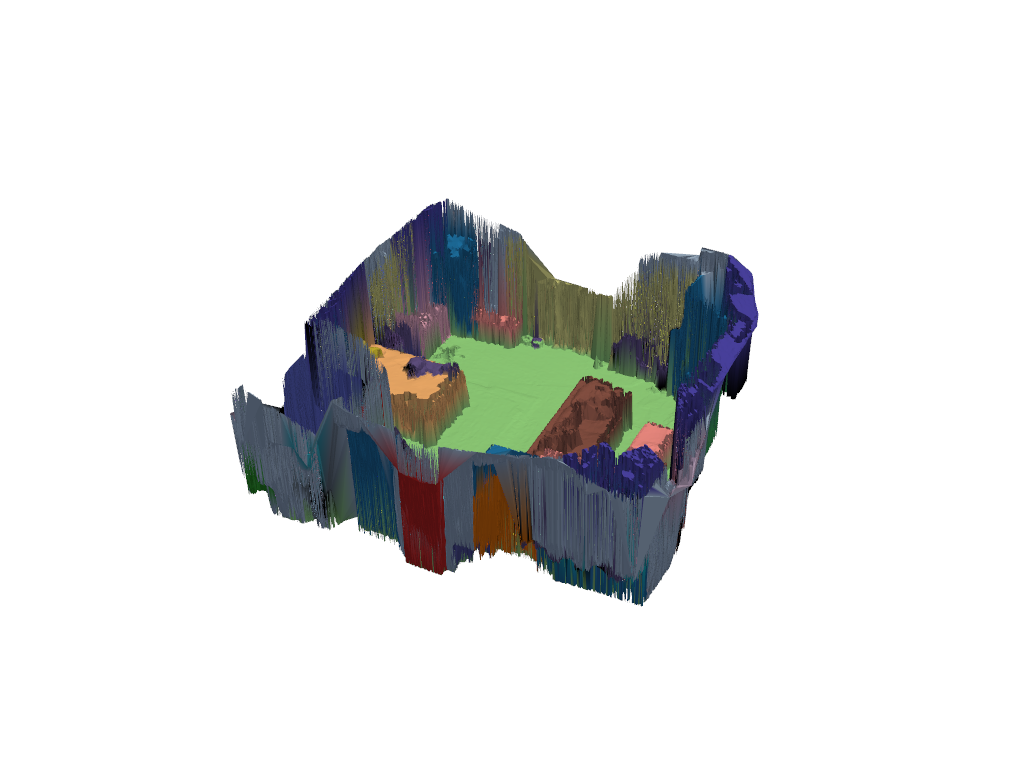

In [7]:
# Plot the mesh
plotter = pv.Plotter()
plotter.add_mesh(mesh, scalars=colors, rgb=True, preference='point')
plotter.show(jupyter_backend=jupyter_backend)
# Save the plot graph in pdf format
# plotter.save_graphic("test1.pdf")

The following is optional for saving mesh

Write and Load point cloud functions (option)

In [ ]:
from plyfile import PlyData, PlyElement

def write_ply(points, save_path: PathLike):
    """
    points: numpy array in shape (N, 6) or (N, 7)
    save_name: str end with ".ply"
    """
    assert points.shape[1] == 6 or points.shape[1] == 7, "points.shape[1] should be 6 or 7"
    save_path = str(save_path)
    assert save_path.endswith(".ply"), "save_name should end with '.ply'"
    points = [
        (points[i, 0], points[i, 1], points[i, 2], points[i, 3], points[i, 4], points[i, 5])
        for i in range(points.shape[0])
    ]
    vertex = np.array(
        points,
        dtype=[
            ("x", "f4"),
            ("y", "f4"),
            ("z", "f4"),
            ("red", "f4"),
            ("green", "f4"),
            ("blue", "f4"),
        ],
    )
    data = PlyElement.describe(vertex, "vertex", comments=["vertices"])
    PlyData([data]).write(save_path)

def read_ply(save_path: PathLike):
    filename = save_path
    with open(filename, 'rb') as f:
        plydata = plyfile.PlyData.read(f)
        num_verts = plydata['vertex'].count
        vertices = np.zeros(shape=[num_verts, 6], dtype=np.float32)
        vertices[:,0] = plydata['vertex'].data['x']
        vertices[:,1] = plydata['vertex'].data['y']
        vertices[:,2] = plydata['vertex'].data['z']
        vertices[:,3] = plydata['vertex'].data['red']
        vertices[:,4] = plydata['vertex'].data['green']
        vertices[:,5] = plydata['vertex'].data['blue']
    return vertices

In [ ]:
# TODO - mesh does not have color information
mesh.save('mesh.vtk')